In [1]:
import numpy as np

F = 100
coupon_rate = 0.03
y = 0.05
T = 10
m = 2

N = T * m
c = coupon_rate * F / m
y_period = y / m

cash_flows = np.array([c] * N)
cash_flows[-1] += F

times = np.arange(1, N + 1) / m

discount_factors = (1 + y_period) ** (-np.arange(1, N + 1))

price = np.sum(cash_flows * discount_factors)

duration = np.sum(times * cash_flows * discount_factors) / price

price, duration

(np.float64(84.4108377143533), np.float64(8.570879486771778))

In [2]:
import numpy as np

F = 100
coupon_rate = 0.07
y = 0.05
T = 10
m = 2

N = T * m
c = coupon_rate * F / m
y_period = y / m

cash_flows = np.array([c] * N)
cash_flows[-1] += F

times = np.arange(1, N + 1) / m

discount_factors = (1 + y_period) ** (-np.arange(1, N + 1))

price = np.sum(cash_flows * discount_factors)

duration = np.sum(times * cash_flows * discount_factors) / price

price, duration

(np.float64(115.58916228564698), np.float64(7.564844312053694))

In [11]:
import numpy as np

F = 100
coupon_rate = 0.05
y = 0.05
T = 10
m = 2

N = T * m
c = coupon_rate * F / m
y_period = y / m

cash_flows = np.array([c] * N)
cash_flows[-1] += F

times = np.arange(1, N + 1) / m

discount_factors = (1 + y_period) ** (-np.arange(1, N + 1))

price = np.sum(cash_flows * discount_factors)

duration = np.sum(times * cash_flows * discount_factors) / price

price, duration

(np.float64(100.00000000000013), np.float64(7.989445671393993))

Duration is a present-value–weighted average time of cash flows.

Low coupon (3%)
Most of the bond’s present value comes from the final principal payment far in the future. Cash flows are concentrated late so it has a longer duration.

Coupon equals yield (5%)
The bond trades at par, and cash flows are more evenly distributed across time. Duration is shorter than the low-coupon case but still substantial.

High coupon (7%)
A larger fraction of the bond’s value is received early through coupons. Cash flows are front-loaded so it is a shorter duration

In [12]:
import pandas as pd
from google.colab import files

uploaded = files.upload()
filename = list(uploaded.keys())[0]

clean_price = pd.read_excel(filename, sheet_name='clean price', index_col=0, parse_dates=True)
duration = pd.read_excel(filename, sheet_name='duration', index_col=0, parse_dates=True)

print("Clean Price:")
display(clean_price.head())

print("Duration:")
display(duration.head())

sec1 = 207391
sec2 = 207392

V1 = 10000

P1 = clean_price.iloc[0][sec1]
D1 = duration.iloc[0][sec1]

P2 = clean_price.iloc[0][sec2]
D2 = duration.iloc[0][sec2]

V2 = V1 * D1 / D2

print(f"To hedge interest rate exposure, take a short position of ${V2:,.2f} in 207392.")

Saving treasury_ts_duration_2025-05-30.xlsx to treasury_ts_duration_2025-05-30 (5).xlsx
Clean Price:


,207391,207392
quote date,,
2019-08-09,98.882812,99.789062
2019-08-12,99.796875,102.554688
2019-08-13,99.281250,101.867188
2019-08-14,100.406250,105.179688
2019-08-15,100.882812,106.234375


Duration:


,207391,207392
quote date,,
2019-08-09,9.289497,22.000102
2019-08-12,9.285468,22.118496
2019-08-13,9.280314,22.084308
2019-08-14,9.282750,22.228549
2019-08-15,9.282163,22.270910


To hedge interest rate exposure, take a short position of $4,222.48 in 207392.


Net duration check (should be ~0 for hedge):


,0
quote date,
2019-08-12,8.531718
2019-08-13,25.020506
2019-08-14,23.728984
2019-08-15,41.958049
2019-08-16,46.349768


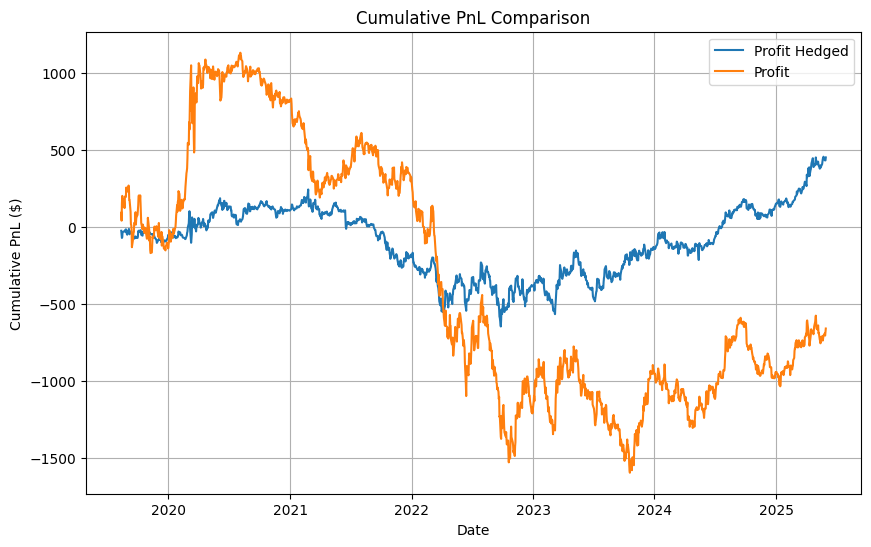

Daily PnL Summary Statistics ($):


,Profit Hedged,Profit
Mean,0.310452,-0.453534
Std,20.851860,43.282811
Min,-98.341110,-321.203791
25%,-10.599297,-25.406113
50%,0.084095,-1.320393
75%,10.690412,22.991809
Max,118.431025,276.272207


In [22]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sec_long = 207391
sec_hedge = 207392
V_long = 10_000

pnl_dynamic = []
pnl_longonly = []
net_duration_check = []

for t in range(len(clean_price)-1):
    P_t = clean_price.iloc[t]
    P_next = clean_price.iloc[t+1]
    D_t = duration.iloc[t]

    units_long = V_long / P_t[sec_long]

    units_hedge = - units_long * D_t[sec_long] / D_t[sec_hedge] * (P_t[sec_long]/P_t[sec_hedge])

    units = pd.Series(0.0, index=clean_price.columns)
    units[sec_long] = units_long
    units[sec_hedge] = units_hedge

    net_duration_check.append(units_long*D_t[sec_long] + units_hedge*D_t[sec_hedge])

    pnl_dynamic.append(np.sum(units * (P_next - P_t)))
    pnl_longonly.append(units_long * (P_next[sec_long] - P_t[sec_long]))

dates = clean_price.index[1:]
pnl_dynamic = pd.Series(pnl_dynamic, index=dates)
pnl_longonly = pd.Series(pnl_longonly, index=dates)
net_duration_check = pd.Series(net_duration_check, index=dates)

print("Net duration check (should be ~0 for hedge):")
display(net_duration_check.head())

plt.figure(figsize=(10,6))
plt.plot(pnl_dynamic.cumsum(), label="Profit Hedged")
plt.plot(pnl_longonly.cumsum(), label="Profit")
plt.xlabel("Date")
plt.ylabel("Cumulative PnL ($)")
plt.title("Cumulative PnL Comparison")
plt.legend()
plt.grid(True)
plt.show()

summary = pd.DataFrame({
    "Profit Hedged": [pnl_dynamic.mean(), pnl_dynamic.std(), pnl_dynamic.min(),
                       pnl_dynamic.quantile(0.25), pnl_dynamic.quantile(0.5), pnl_dynamic.quantile(0.75),
                       pnl_dynamic.max()],
    "Profit": [pnl_longonly.mean(), pnl_longonly.std(), pnl_longonly.min(),
                  pnl_longonly.quantile(0.25), pnl_longonly.quantile(0.5), pnl_longonly.quantile(0.75),
                  pnl_longonly.max()]
}, index=["Mean", "Std", "Min", "25%", "50%", "75%", "Max"])

print("Daily PnL Summary Statistics ($):")
display(summary)

1. Duration is only a linear approximation

Duration measures the first-order sensitivity of a bond’s price to small changes in yield. This is linear, so it assumes small parallel shifts in the yield curve.

As a result, even a perfectly duration-hedged position can have residual PnL from non-linear price changes.

2. Hedging assumes only one source of risk

Other factors affect bond prices, such as:

Coupon payments,

Changes in credit spreads (for corporate bonds),

Accrued interest variations,

Market microstructure effects.

Even if the interest rate risk (duration) is hedged, these other factors cause daily PnL to fluctuate.

In [23]:
import pandas as pd

df['quote date'] = pd.to_datetime(df['quote date'])

df = df.sort_values('quote date')

bonds = df['maturity date'].unique()

coupon_dict = {}

for bond in bonds:
    bond_df = df[df['maturity date'] == bond].copy()

    bond_df = bond_df.set_index('quote date')

    ai_diff = bond_df['accrued int'].diff()
    coupon_dates = ai_diff[ai_diff < 0].index

    cpn_rate = bond_df['cpn rate'].iloc[0]
    coupon_payment = 100 * cpn_rate / 2 / 100

    coupon_series = pd.Series(0, index=bond_df.index)
    coupon_series.loc[coupon_dates] = coupon_payment

    coupon_dict[bond] = coupon_series

coupon_df = pd.DataFrame(coupon_dict)

print("First 5 coupon payments for either bond:")
display(coupon_df[coupon_df>0].stack().head(5))

First 5 coupon payments for either bond:


/tmp/ipython-input-3505779775.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '0.8125' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  coupon_series.loc[coupon_dates] = coupon_payment
/tmp/ipython-input-3505779775.py:35: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '1.125' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  coupon_series.loc[coupon_dates] = coupon_payment


quote date            
2020-02-18  2029-08-15    0.8125
            2049-08-15    1.1250
2020-08-17  2029-08-15    0.8125
            2049-08-15    1.1250
2021-02-16  2029-08-15    0.8125
dtype: float64

Daily PnL Summary Statistics ($) Including Coupons:


,Profit Hedged,Profit
Mean,0.738148,0.191307
Std,20.852995,43.282811
Min,-97.950719,-320.558950
25%,-10.203904,-24.761272
50%,0.520347,-0.675552
75%,11.143334,23.636650
Max,118.851423,276.917048


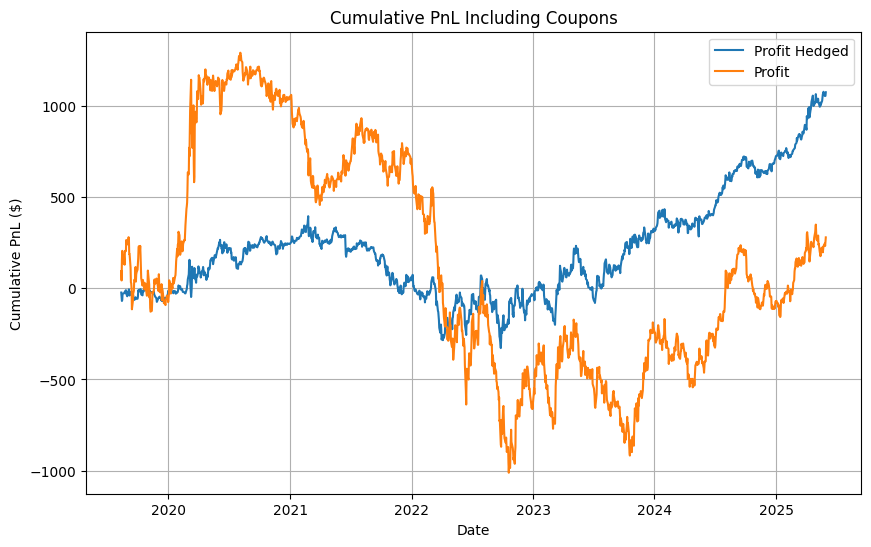

In [32]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

sec_long = 207391
sec_hedge = 207392
V_long = 10_000
accrual_fraction = 1/252
cpn_rate = 0.01625

pnl_dynamic = []
pnl_longonly = []
net_duration_check = []

for t in range(len(clean_price)-1):
    P_t = clean_price.iloc[t]
    P_next = clean_price.iloc[t+1]
    D_t = duration.iloc[t]

    units_long = V_long / P_t[sec_long]
    units_hedge = - units_long * D_t[sec_long] / D_t[sec_hedge] * (P_t[sec_long]/P_t[sec_hedge])

    units = pd.Series(0.0, index=clean_price.columns)
    units[sec_long] = units_long
    units[sec_hedge] = units_hedge

    net_duration_check.append(units_long*D_t[sec_long] + units_hedge*D_t[sec_hedge])

    pnl_price = np.sum(units * (P_next - P_t))

    pnl_coupons = np.sum(units * cpn_rate * accrual_fraction * P_t)

    pnl_dynamic.append(pnl_price + pnl_coupons)

    pnl_longonly.append(
        units_long * (P_next[sec_long] - P_t[sec_long]) +
        units_long * cpn_rate * accrual_fraction * P_t[sec_long]
    )

dates = clean_price.index[1:]
pnl_dynamic = pd.Series(pnl_dynamic, index=dates)
pnl_longonly = pd.Series(pnl_longonly, index=dates)
net_duration_check = pd.Series(net_duration_check, index=dates)

summary = pd.DataFrame({
    "Profit Hedged": [pnl_dynamic.mean(), pnl_dynamic.std(), pnl_dynamic.min(),
                      pnl_dynamic.quantile(0.25), pnl_dynamic.quantile(0.5), pnl_dynamic.quantile(0.75),
                      pnl_dynamic.max()],
    "Profit": [pnl_longonly.mean(), pnl_longonly.std(), pnl_longonly.min(),
               pnl_longonly.quantile(0.25), pnl_longonly.quantile(0.5), pnl_longonly.quantile(0.75),
               pnl_longonly.max()]
}, index=["Mean", "Std", "Min", "25%", "50%", "75%", "Max"])

print("Daily PnL Summary Statistics ($) Including Coupons:")
display(summary)

plt.figure(figsize=(10,6))
plt.plot(pnl_dynamic.cumsum(), label="Profit Hedged")
plt.plot(pnl_longonly.cumsum(), label="Profit")
plt.xlabel("Date")
plt.ylabel("Cumulative PnL ($)")
plt.title("Cumulative PnL Including Coupons")
plt.legend()
plt.grid(True)
plt.show()

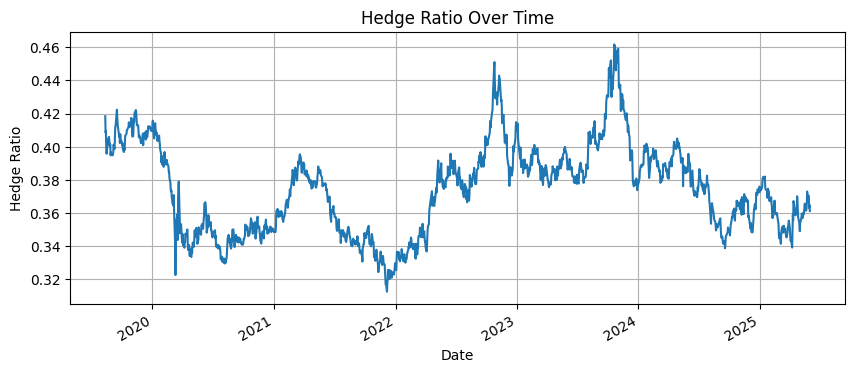

In [33]:
hedge_ratio = []

for t in range(len(clean_price)-1):
    P_t = clean_price.iloc[t]
    D_t = duration.iloc[t]

    units_long = V_long / P_t[sec_long]
    units_hedge = - units_long * D_t[sec_long] / D_t[sec_hedge] * (P_t[sec_long]/P_t[sec_hedge])

    hedge_ratio.append(abs(units_hedge / units_long))

hedge_ratio = pd.Series(hedge_ratio, index=clean_price.index[1:])
hedge_ratio.plot(figsize=(10,4), title="Hedge Ratio Over Time")
plt.xlabel("Date")
plt.ylabel("Hedge Ratio")
plt.grid(True)
plt.show()

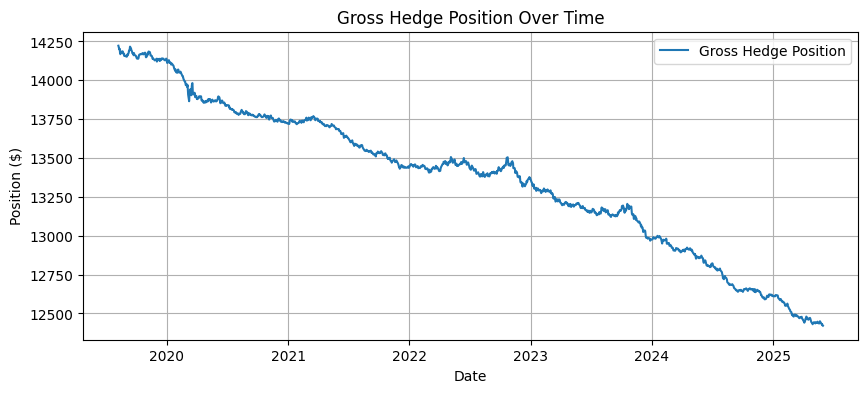

In [41]:
gross_hedge = []

for t in range(len(clean_price)):
    P_t = clean_price.iloc[t]
    D_t = duration.iloc[t]

    units_long = V_long / P_t[sec_long]
    units_hedge = - units_long * D_t[sec_long] / D_t[sec_hedge] * (P_t[sec_long]/P_t[sec_hedge])

    gross_hedge.append(abs(units_hedge) * P_t[sec_hedge] + 10000)

gross_hedge = pd.Series(gross_hedge, index=clean_price.index)

plt.figure(figsize=(10,4))
plt.plot(gross_hedge, label="Gross Hedge Position")
plt.title("Gross Hedge Position Over Time")
plt.xlabel("Date")
plt.ylabel("Position ($)")
plt.legend()
plt.grid(True)
plt.show()
